# 1. Exploración

Importo las librerías necesarias

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from collections import Counter
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from wordcloud import WordCloud

## Carga de datos

Para este ejercicio utilizo el dataset de IMDb Movie Reviews que contiene 50,000 reviews de películas clasificadas como positivas o negativas.

El dataset tiene:
- review: texto de la opinión
- sentiment: positive o negative

In [2]:
df = pd.read_csv('./IMDB Dataset.csv')

Informacion general del dataset

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Como el dataset original solo tiene sentimiento positivo/negativo, voy a asignar ratings de estrellas para poder hacer análisis similares al ejemplo de clase:
- Positivas: 4-5 estrellas
- Negativas: 1-2 estrellas

In [5]:

np.random.seed(42)
positive_mask = df['sentiment'] == 'positive'
df.loc[positive_mask, 'overall'] = np.random.choice([4, 5], size=positive_mask.sum(), p=[0.3, 0.7])

negative_mask = df['sentiment'] == 'negative'
df.loc[negative_mask, 'overall'] = np.random.choice([1, 2], size=negative_mask.sum(), p=[0.7, 0.3])

Renombro columna para consistencia

In [6]:
df = df.rename(columns={'review': 'reviewText'})

Distribución de reviews por número de estrellas

In [7]:
df['overall'].value_counts().sort_index()

1.0    17662
2.0     7338
4.0     7426
5.0    17574
Name: overall, dtype: int64

Por ultimo, visualizo la distribución de reviews por número de estrellas en un gráfico de barras.


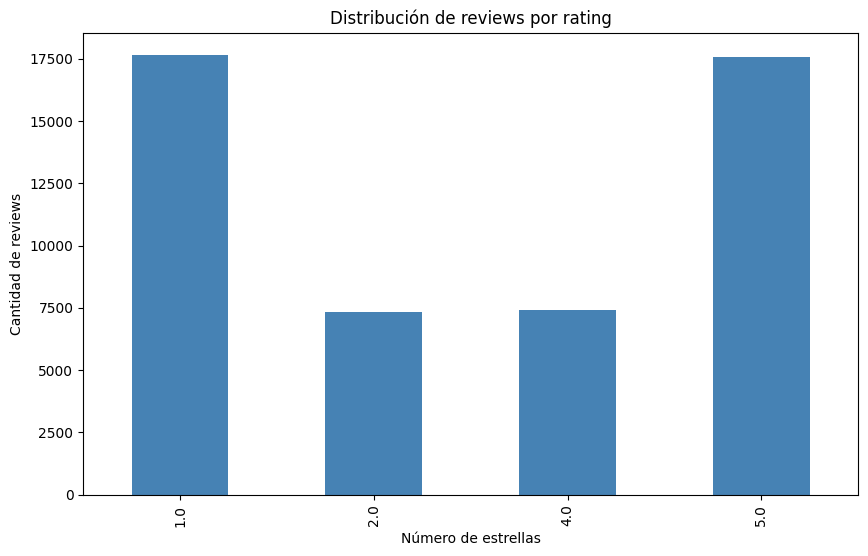

In [8]:
plt.figure(figsize=(10, 6))
df['overall'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.xlabel('Número de estrellas')
plt.ylabel('Cantidad de reviews')
plt.title('Distribución de reviews por rating')
plt.show()

Voy a separar las reviews en positivas 4-5 estrellas y negativas 1-2 estrellas.

In [9]:
df_positive = df[df['overall'] >= 4]
df_negative = df[df['overall'] <= 2]

In [10]:
print(f"Reviews positivas: {len(df_positive)}")
print(f"Reviews negativas: {len(df_negative)}")


Reviews positivas: 25000
Reviews negativas: 25000


Para trabajar con un subset manejable, voy a seleccionar una muestra de reviews.

In [11]:
sample_positive = df_positive.sample(n=5000, random_state=42)
sample_negative = df_negative.sample(n=5000, random_state=42)

df_sample = pd.concat([sample_positive, sample_negative])
print(f"Total de reviews: {len(df_sample)}")

Total de reviews: 10000


## Preprocesamiento de texto

Ahora voy a limpiar y tokenizar el texto para poder analizarlo.

In [12]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

Aplicar limpieza

In [13]:
df_sample['reviewText_clean'] = df_sample['reviewText'].apply(clean_text)

Ejemplo de texto limpio

In [14]:
print("Original:")
print(df_sample.iloc[0]['reviewText'][:200])
print("\nLimpio:")
print(df_sample.iloc[0]['reviewText_clean'][:200])

Original:
I don't know how or why this film has a meager rating on IMDb. This film, accompanied by "I am Curious: Blue" is a masterwork.<br /><br />The only thing that will let you down in this film is if you d

Limpio:
i dont know how or why this film has a meager rating on imdb this film accompanied by i am curious blue is a masterworkthe only thing that will let you down in this film is if you dont like the proces


Ahora tokenizo el texto.

In [15]:
df_sample['tokens'] = df_sample['reviewText_clean'].apply(lambda x: x.split())

In [16]:
df_sample.iloc[0]['tokens'][:20]

['i',
 'dont',
 'know',
 'how',
 'or',
 'why',
 'this',
 'film',
 'has',
 'a',
 'meager',
 'rating',
 'on',
 'imdb',
 'this',
 'film',
 'accompanied',
 'by',
 'i',
 'am']

## Cardinalidad del vocabulario

Voy a contar cuántas palabras únicas hay en el corpus.

Palabras más frecuentes

In [17]:
df_sample['tokens_clean'] = df_sample['tokens'].apply(
    lambda tokens: [w for w in tokens if len(w) > 2]
)

all_tokens = [token for tokens in df_sample['tokens_clean'] for token in tokens]

In [18]:
word_freq = Counter(all_tokens)

top_20 = word_freq.most_common(20)
top_20

[('the', 129389),
 ('and', 63419),
 ('this', 29139),
 ('that', 27168),
 ('was', 19017),
 ('with', 17410),
 ('for', 17242),
 ('movie', 16680),
 ('but', 15925),
 ('film', 14983),
 ('you', 11877),
 ('not', 11829),
 ('are', 11686),
 ('his', 11290),
 ('have', 10957),
 ('one', 10245),
 ('its', 9599),
 ('all', 8835),
 ('they', 8212),
 ('who', 7988)]

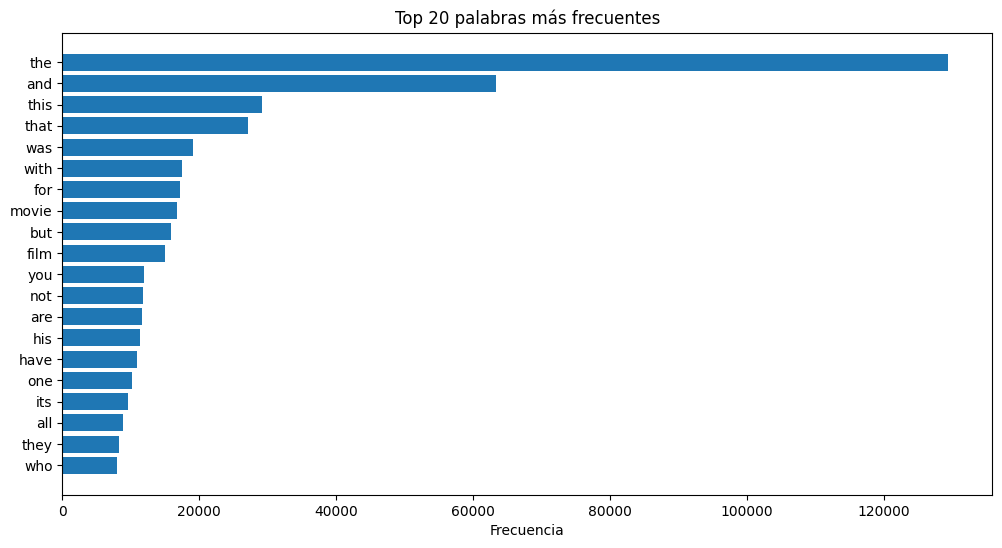

In [19]:
words, counts = zip(*top_20)

plt.figure(figsize=(12, 6))
plt.barh(range(len(words)), counts)
plt.yticks(range(len(words)), words)
plt.xlabel('Frecuencia')
plt.title('Top 20 palabras más frecuentes')
plt.gca().invert_yaxis()
plt.show()

Ahora voy a ver las palabras más frecuentes en reviews positivas y negativas por separado.

In [20]:
tokens_positive = [token for tokens in df_sample[df_sample['overall'] >= 4]['tokens_clean'] 
                   for token in tokens]

tokens_negative = [token for tokens in df_sample[df_sample['overall'] <= 2]['tokens_clean'] 
                   for token in tokens]

In [21]:
freq_positive = Counter(tokens_positive)
print("Top 10 palabras en reviews positivas:")

freq_positive.most_common(10)

Top 10 palabras en reviews positivas:


[('the', 66054),
 ('and', 34487),
 ('this', 13397),
 ('that', 13257),
 ('with', 9114),
 ('for', 8773),
 ('was', 8481),
 ('film', 8046),
 ('but', 7780),
 ('movie', 7287)]

In [22]:
freq_negative = Counter(tokens_negative)
print("Top 10 palabras en reviews negativas:")
freq_negative.most_common(10)

Top 10 palabras en reviews negativas:


[('the', 63335),
 ('and', 28932),
 ('this', 15742),
 ('that', 13911),
 ('was', 10536),
 ('movie', 9393),
 ('for', 8469),
 ('with', 8296),
 ('but', 8145),
 ('film', 6937)]

## N-gramas más frecuentes

Voy a analizar bigramas y trigramas.

In [23]:
def get_ngrams(tokens_list, n):
    ngrams = []
    for tokens in tokens_list:
        for i in range(len(tokens) - n + 1):
            ngram = tuple(tokens[i:i+n])
            ngrams.append(ngram)
    return ngrams

In [24]:
bigrams = get_ngrams(df_sample['tokens_clean'].tolist(), 2)

print(f"Total de bigramas: {len(bigrams):,}")

Total de bigramas: 1,780,409


Bigramas más frecuentes

In [25]:
bigram_freq = Counter(bigrams)
top_bigrams = bigram_freq.most_common(15)

print("Top 15 bigramas:")
for bigram, count in top_bigrams:
    print(f"{' '.join(bigram):30s} {count:5d}")

Top 15 bigramas:
this movie                      5930
and the                         5603
the film                        4776
the movie                       4261
this film                       4112
for the                         3237
with the                        3161
that the                        2397
from the                        2385
one the                         2178
all the                         2034
the story                       1877
the first                       1714
have been                       1703
but the                         1522


Generar trigramas

In [26]:
trigrams = get_ngrams(df_sample['tokens_clean'].tolist(), 3)

print(f"Total de trigramas: {len(trigrams):,}")

Total de trigramas: 1,770,409


Trigramas más frecuentes

In [27]:
trigram_freq = Counter(trigrams)
top_trigrams = trigram_freq.most_common(15)

print("Top 15 trigramas:")
for trigram, count in top_trigrams:
    print(f"{' '.join(trigram):40s} {count:5d}")

Top 15 trigramas:
the fact that                              573
this movie was                             512
the rest the                               404
one the most                               355
the end the                                354
could have been                            344
would have been                            335
one the best                               328
the movie was                              291
this movie the                             253
this film was                              245
the characters are                         236
this movie and                             234
the film was                               232
have ever seen                             225


## Nubes de palabras

Las nubes de palabras permiten visualizar las palabras más frecuentes de forma gráfica.

In [28]:
text_all = ' '.join(all_tokens)

Nube de palabras de todas las reviews

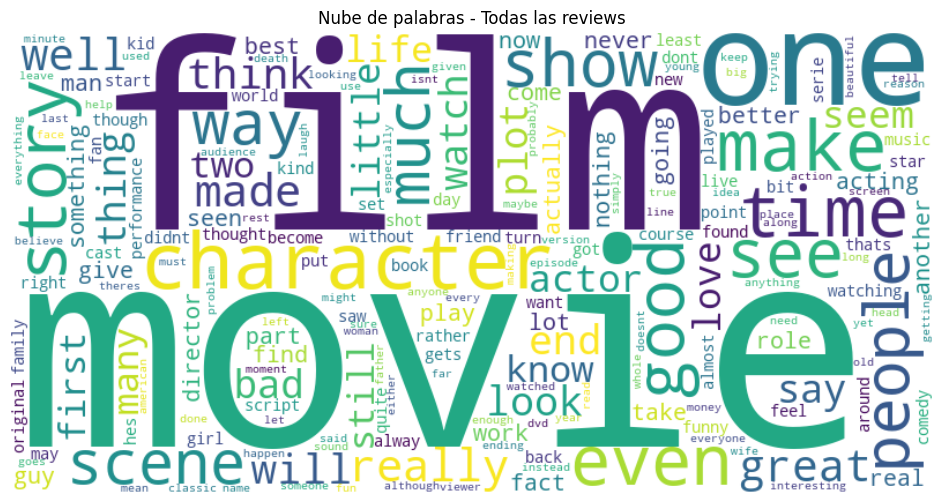

In [29]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Todas las reviews')
plt.show()

Nube de palabras de reviews positivas

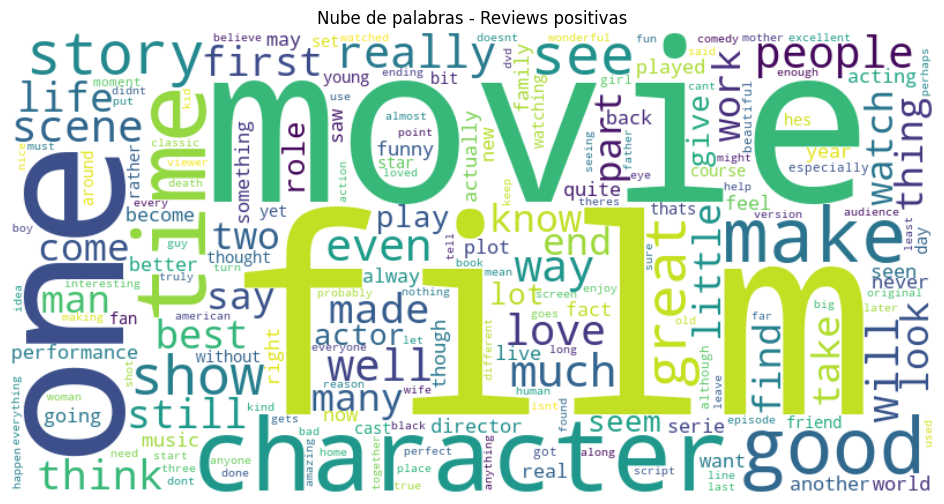

In [30]:
text_positive = ' '.join(tokens_positive)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(text_positive)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Reviews positivas')
plt.show()

Nube de palabras de reviews negativas

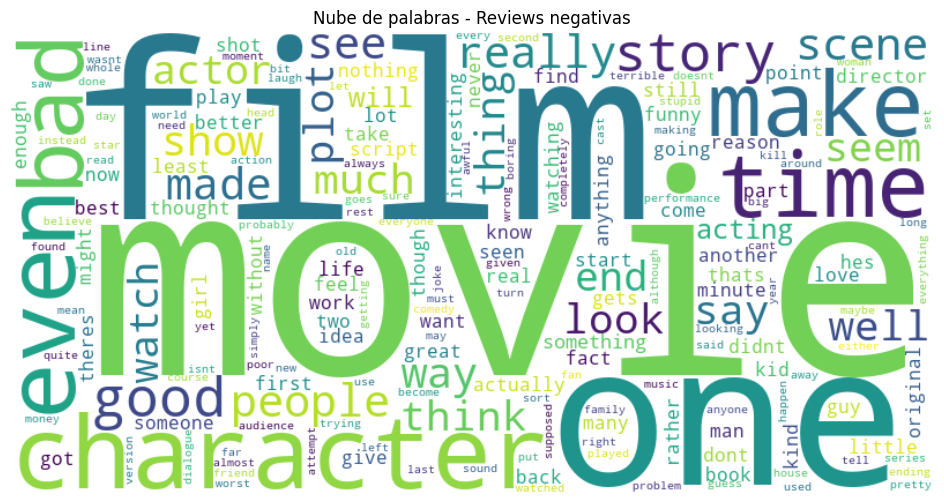

In [31]:
text_negative = ' '.join(tokens_negative)

wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(text_negative)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Reviews negativas')
plt.show()

## Word Embeddings con Word2Vec

Voy a entrenar un modelo Word2Vec para obtener representaciones vectoriales de las palabras. Esto me permite encontrar palabras similares semánticamente.

In [32]:
sentences = df_sample['tokens_clean'].tolist()

print(f"Número de documentos: {len(sentences)}")

Número de documentos: 10000


Entrenar modelo Word2Vec

In [33]:
model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=0
)

print(f"Vocabulario del modelo: {len(model.wv)} palabras")

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Vocabulario del modelo: 18373 palabras


Ahora voy a buscar palabras similares para algunas palabras clave relacionadas con películas.

In [34]:
if 'movie' in model.wv:
    similar = model.wv.most_similar('movie', topn=10)
    print("Palabras similares a 'movie':")
    for word, score in similar:
        print(f"  {word:15s} {score:.3f}")

Palabras similares a 'movie':
  film            0.889
  flick           0.746
  sequel          0.738
  show            0.718
  documentary     0.718
  series          0.695
  picture         0.692
  mess            0.671
  viewing         0.668
  review          0.665


In [35]:
if 'good' in model.wv:
    similar = model.wv.most_similar('good', topn=10)
    print("Palabras similares a 'good':")
    for word, score in similar:
        print(f"  {word:15s} {score:.3f}")

Palabras similares a 'good':
  bad             0.748
  decent          0.736
  great           0.716
  nice            0.680
  sure            0.666
  cool            0.660
  impressed       0.654
  okay            0.642
  awesome         0.638
  funny           0.631


In [36]:
if 'bad' in model.wv:
    similar = model.wv.most_similar('bad', topn=10)
    print("Palabras similares a 'bad':")
    for word, score in similar:
        print(f"  {word:15s} {score:.3f}")

Palabras similares a 'bad':
  awful           0.753
  good            0.748
  horrible        0.743
  stupid          0.740
  terrible        0.705
  sure            0.667
  damn            0.666
  funny           0.646
  awesome         0.641
  okay            0.635


In [37]:
if 'story' in model.wv:
    similar = model.wv.most_similar('story', topn=10)
    print("Palabras similares a 'story':")
    for word, score in similar:
        print(f"  {word:15s} {score:.3f}")

Palabras similares a 'story':
  plot            0.780
  storyline       0.703
  premise         0.687
  script          0.634
  tale            0.632
  theme           0.605
  concept         0.597
  idea            0.577
  stories         0.569
  book            0.554


## Visualización de embeddings en 2D

Para visualizar los embeddings, voy a reducir la dimensionalidad de 100 a 2 usando t-SNE.

Selecciono 4 palabras clave y visualizo sus 10 palabras más similares.

In [38]:
keywords = ['movie', 'good', 'bad', 'story']

keywords = [w for w in keywords if w in model.wv]
print(f"Palabras clave a visualizar: {keywords}")

Palabras clave a visualizar: ['movie', 'good', 'bad', 'story']


In [39]:
words_to_plot = []
vectors_to_plot = []
word_labels = []

for keyword in keywords:
    words_to_plot.append(keyword)
    vectors_to_plot.append(model.wv[keyword])
    word_labels.append(keyword)
    
    similar = model.wv.most_similar(keyword, topn=10)
    for word, _ in similar:
        words_to_plot.append(word)
        vectors_to_plot.append(model.wv[word])
        word_labels.append(keyword)

vectors_to_plot = np.array(vectors_to_plot)
print(f"Total de palabras a visualizar: {len(words_to_plot)}")

Total de palabras a visualizar: 44


Aplicar t-SNE para reducir dimensionalidad

In [40]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
vectors_2d = tsne.fit_transform(vectors_to_plot)

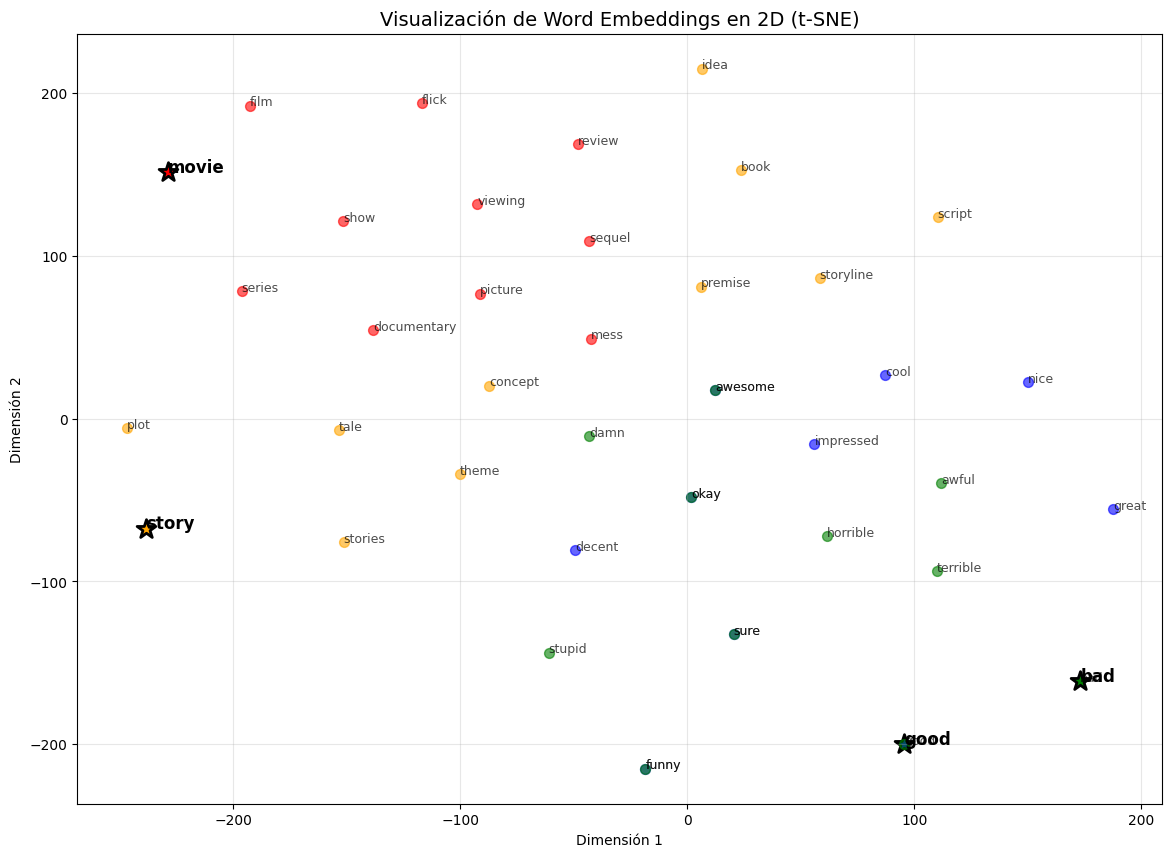

In [41]:
plt.figure(figsize=(14, 10))

colors = ['red', 'blue', 'green', 'orange', 'purple']
color_map = {word: colors[i] for i, word in enumerate(keywords)}

for i, word in enumerate(words_to_plot):
    x, y = vectors_2d[i]
    label = word_labels[i]
    color = color_map[label]
    
    if word == label:
        plt.scatter(x, y, c=color, s=200, marker='*', edgecolors='black', linewidths=2)
        plt.annotate(word, (x, y), fontsize=12, fontweight='bold')
    else:
        plt.scatter(x, y, c=color, s=50, alpha=0.6)
        plt.annotate(word, (x, y), fontsize=9, alpha=0.7)

plt.title('Visualización de Word Embeddings en 2D (t-SNE)', fontsize=14)
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.grid(True, alpha=0.3)
plt.show()

## Conclusiones

En este análisis exploratorio del dataset de IMDb he observado lo siguiente:

Sobre el vocabulario:
- El corpus tiene un vocabulario rico con miles de palabras únicas
- Las palabras más frecuentes están relacionadas con películas: film, movie, good, great, etc.
- Existe una clara diferencia en el vocabulario entre reviews positivas y negativas

Sobre los n-gramas:
- Los bigramas y trigramas capturan expresiones comunes en reviews de películas
- En reviews positivas aparecen frases como "great movie", "good film"
- En reviews negativas aparecen frases como "waste time", "bad movie"

Sobre Word2Vec:
- El modelo captura relaciones semánticas interesantes
- Palabras con significados similares aparecen cercanas en el espacio vectorial
- La visualización en 2D muestra clusters de palabras relacionadas